In [1]:
import os
os.chdir('..')

In [2]:
from metaworld.envs import (ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE)

from buffers import MultiEnvReplayBuffer
from bnn import BNN
from cem_optimizer_v2 import CEM_opt
from planner_module_v4 import Planner
from lion_opt import Lion

from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np
import torchbnn as bnn
import torch
import tqdm
import json
import random

In [3]:

def json_load():
    with open('config_parameters.json', 'r') as f:
        config_file = json.load(f)
    return config_file


def save_json_update(json_obj):
    with open('config_parameters.json', 'w') as f:
        json.dump(json_obj, f)

config = json_load()


# nested struct
buff_config = config['buffer']
planner_config = config['planner']
const_config = config['const']
train_config = config['train']
'''
i load only the var that i need inside the
traininig loop, not in the initialization of the
object. If each time i should look inside the dict,
i'll consume operation
'''
DEVICE = const_config['DEVICE']
BATCH_SIZE = 512
KL_WEIGHT = train_config['KL_WEIGHT']
EPISODE_FOR_TASK = train_config['EPISODE_FOR_TASK']

In [4]:
#envs_name = list(ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE.keys())
# select best dataset for task : the ones that contains also the solved task, or at least some good performance
envs_name = [
    'button-press-v2-goal-observable',  # rew 9.19
    'button-press-wall-v2-goal-observable',  # rew 8.39, 
    'coffee-button-v2-goal-observable',  # rew 9.26
    'door-close-v2-goal-observable',  # rew 5.83
    'handle-press-v2-goal-observable', # rew 10
    'handle-press-side-v2-goal-observable', #rew 10
    'reach-wall-v2-goal-observable', #rew 10
    'plate-slide-back-v2-goal-observable', # rew 6.99
    'plate-slide-side-v2-goal-observable', # rew 4.46
    'plate-slide-v2-goal-observable', # rew 6.77
    'push-v2-goal-observable', # rew 5.17
    'reach-v2-goal-observable', # rew 10    
]


envs = {}
for name in random.sample(envs_name,  10):
    print(f'selected_env: {name}')
    if not buff_config["correspondence_id2env"].get(name, 0):
        buff_config["correspondence_id2env"][name] = buff_config["correspondence_id2env"]["first_idx_free"]
        buff_config["correspondence_id2env"]["first_idx_free"] += 1
    envs[buff_config["correspondence_id2env"][name]] = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[name]()

config['buffer'] = buff_config
save_json_update(config)



selected_env: plate-slide-back-v2-goal-observable
selected_env: plate-slide-side-v2-goal-observable
selected_env: coffee-button-v2-goal-observable


/home/dema/PycharmProjects/lifelong_rl/venv/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/dema/PycharmProjects/lifelong_rl/venv/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


selected_env: door-close-v2-goal-observable
selected_env: reach-wall-v2-goal-observable
selected_env: button-press-v2-goal-observable
selected_env: handle-press-v2-goal-observable
selected_env: plate-slide-v2-goal-observable
selected_env: button-press-wall-v2-goal-observable
selected_env: push-v2-goal-observable


In [5]:
multibuffer = MultiEnvReplayBuffer(
    buffer_size_per_env=9_000
)

multibuffer.read_buffers('buffer_stock/buffers_cem_solve/')

old buffer to load: name: ['buffer_env48.pkl', 'buffer_env22.pkl', 'buffer_env41.pkl', 'buffer_env43.pkl', 'buffer_env29.pkl', 'buffer_env09.pkl', 'buffer_env34.pkl', 'buffer_env40.pkl', 'buffer_env26.pkl', 'buffer_env01.pkl', 'buffer_env10.pkl', 'buffer_env13.pkl', 'buffer_env42.pkl', 'buffer_env49.pkl', 'buffer_env19.pkl', 'buffer_env45.pkl', 'buffer_env46.pkl', 'buffer_env35.pkl', 'buffer_env32.pkl', 'buffer_env50.pkl', 'buffer_env04.pkl', 'buffer_env15.pkl', 'buffer_env28.pkl', 'buffer_env20.pkl', 'buffer_env06.pkl', 'buffer_env18.pkl', 'buffer_env07.pkl', 'buffer_env33.pkl', 'buffer_env12.pkl', 'buffer_env16.pkl', 'buffer_env11.pkl', 'buffer_env23.pkl', 'buffer_env36.pkl', 'buffer_env05.pkl', 'buffer_env08.pkl', 'buffer_env30.pkl', 'buffer_env37.pkl', 'buffer_env14.pkl', 'buffer_env38.pkl', 'buffer_env24.pkl', 'buffer_env39.pkl', 'buffer_env17.pkl', 'buffer_env21.pkl', 'buffer_env44.pkl', 'buffer_env25.pkl', 'buffer_env31.pkl', 'buffer_env27.pkl', 'buffer_env03.pkl', 'buffer_env02

In [6]:
multibuffer.elem_for_buffer

defaultdict(<function buffers.MultiEnvReplayBuffer.__init__.<locals>.<lambda>()>,
            {48: 800,
             22: 800,
             41: 800,
             43: 800,
             29: 800,
             9: 800,
             34: 800,
             40: 800,
             26: 800,
             1: 800,
             10: 800,
             13: 800,
             42: 800,
             49: 800,
             19: 800,
             45: 800,
             46: 800,
             35: 800,
             32: 800,
             50: 800,
             4: 800,
             15: 800,
             28: 800,
             20: 800,
             6: 800,
             18: 800,
             7: 800,
             33: 800,
             12: 800,
             16: 800,
             11: 800,
             23: 800,
             36: 1000,
             5: 800,
             8: 800,
             30: 800,
             37: 800,
             14: 800,
             38: 800,
             24: 800,
             39: 800,
             17: 800,


In [7]:

for k in envs.keys():
    #if multibuffer.elem_for_buffer[k] == 0:
        # if not any sample for that exp: do random move
        print(f'adding random step for model {k}')
        for _ in range(100):   # num ep
            s = envs[k].reset()
            for _ in range(40):  # num step
                act = envs[k].action_space.sample()
                new_s, reward, done, info = envs[k].step(act)
                multibuffer.add(s, act, reward, new_s, done, env_id=k)
                s = new_s

adding random step for model 1
adding random step for model 4
adding random step for model 36
adding random step for model 45
adding random step for model 25
adding random step for model 37
adding random step for model 26
adding random step for model 35
adding random step for model 29
adding random step for model 18


In [8]:
multibuffer.elem_for_buffer

defaultdict(<function buffers.MultiEnvReplayBuffer.__init__.<locals>.<lambda>()>,
            {48: 800,
             22: 800,
             41: 800,
             43: 800,
             29: 4800,
             9: 800,
             34: 800,
             40: 800,
             26: 4800,
             1: 4800,
             10: 800,
             13: 800,
             42: 800,
             49: 800,
             19: 800,
             45: 4800,
             46: 800,
             35: 4800,
             32: 800,
             50: 800,
             4: 4800,
             15: 800,
             28: 800,
             20: 800,
             6: 800,
             18: 4800,
             7: 800,
             33: 800,
             12: 800,
             16: 800,
             11: 800,
             23: 800,
             36: 5000,
             5: 800,
             8: 800,
             30: 800,
             37: 4800,
             14: 800,
             38: 800,
             24: 800,
             39: 800,
             1

In [9]:
buffer_test = MultiEnvReplayBuffer(500)

for k in envs.keys():
# fill test buff
    for ep in range(30): 
        s = envs[k].reset()
        for h in range(20):
            a = envs[k].action_space.sample()
            s_prime, rew, done, info = envs[k].step(a)
            buffer_test.add(s, a, rew, s_prime, done, env_id=k)

In [10]:
def train_with_elbo(net, buffer, optimizer, mse_loss, kl_loss, task_id):
    """
   training loop
    """
    states, actions, rewards, next_states, dones = buffer.sample_all_envs(batch_size=512) if (task_id == -1) else buffer.sample_env(task_id, batch_size=BATCH_SIZE)

    optimizer.zero_grad()
    x = torch.Tensor(np.concatenate((states, actions), axis=-1)).to(DEVICE)
    y_true = torch.Tensor(np.concatenate((next_states, rewards), axis=-1)).to(DEVICE)
    y_pred = net(x)

    mse = mse_loss(y_pred, y_true)
    kl = kl_loss(net)
    loss = mse + KL_WEIGHT * kl
    loss.backward()
    optimizer.step()
    return mse.item(), kl.item(), loss.item()


def test_with_elbo(net, buffer, mse_loss, kl_loss, task_id):
    """
   test loop
        """
    states, actions, rewards, next_states, dones = buffer.sample_all_envs(batch_size=256) if (task_id == -1) else buffer.sample_env(task_id, batch_size=BATCH_SIZE)

    with torch.no_grad():
        
        x = torch.Tensor(np.concatenate((states, actions), axis=-1)).to(DEVICE)
        y_true = torch.Tensor(np.concatenate((next_states, rewards), axis=-1)).to(DEVICE)
        y_pred = net(x)

        mse = mse_loss(y_pred, y_true)
        kl = kl_loss(net)
        loss = mse + KL_WEIGHT * kl
    
    return mse.item(), kl.item(), loss.item()


In [15]:
LR = 1e-4
dynamic = BNN(action_dim=4, obs_dim=39, reward_dim=1).to(DEVICE)
optim = Lion(dynamic.parameters(), lr=LR)
counter_train = 0

kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(DEVICE)
mse_loss = torch.nn.MSELoss().to(DEVICE)

In [16]:
mse_history = []
kl_history = []
loss_tot_history = []

mse_history_test = []
kl_history_test = []
loss_tot_history_test = []

In [17]:
env_key = list(envs.keys())[0]
epochs = 20_000
counter_train += epochs

for ep in tqdm.tqdm(range(epochs)):
    
    mse, kl, loss = train_with_elbo(
        net=dynamic,
        buffer=multibuffer,
        optimizer=optim,
        mse_loss=mse_loss,
        kl_loss=kl_loss,
        task_id=-1
    )
    mse_history.append(mse)
    kl_history.append(kl)
    loss_tot_history.append(loss)
    
    mse, kl, loss = test_with_elbo(
        net=dynamic,
        buffer=buffer_test,
        mse_loss=mse_loss,
        kl_loss=kl_loss,
        task_id=-1
    )
    mse_history_test.append(mse)
    kl_history_test.append(kl)
    loss_tot_history_test.append(loss)


100%|████████████████████████████████████████████████████████████████████| 20000/20000 [01:53<00:00, 176.27it/s]


'avg loss for last 500 ep: 0.13218173494935034, counter_train=20000, test_loss last 500 ep: 0.06601538436114789'

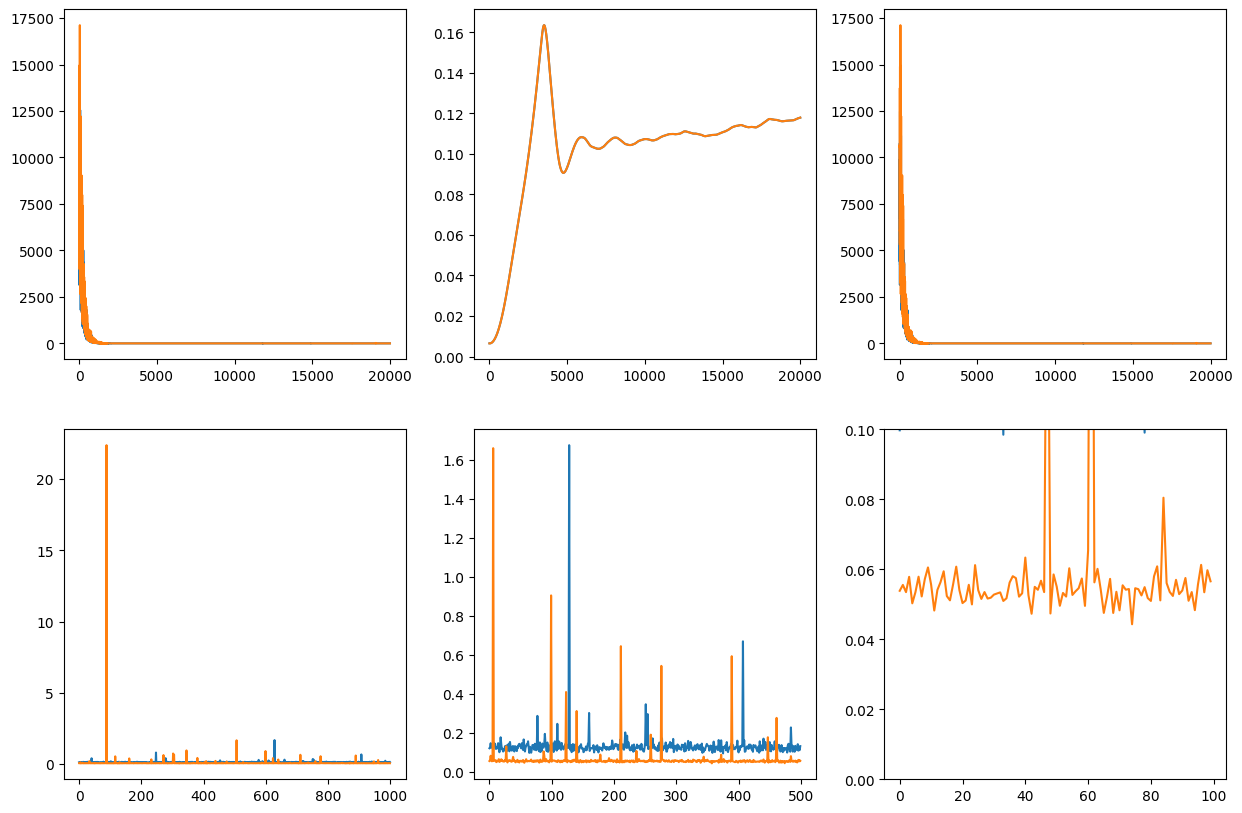

In [18]:
fig, axis = plt.subplots(2, 3, figsize=(15, 10))

axis[0, 0].plot(mse_history)
axis[0, 0].plot(mse_history_test)

axis[0, 1].plot(kl_history)
axis[0, 1].plot(kl_history_test)

axis[0, 2].plot(loss_tot_history)
axis[0, 2].plot(loss_tot_history_test)

# zoom
axis[1, 0].plot(mse_history[-1000:])
axis[1, 0].plot(mse_history_test[-1000:])

axis[1, 1].plot(mse_history[-500:])
axis[1, 1].plot(mse_history_test[-500:])

axis[1, 2].plot(mse_history[-100:])
axis[1, 2].plot(mse_history_test[-100:])
axis[1, 2].set_ylim(0, 0.1)
f'avg loss for last 500 ep: {sum(loss_tot_history[-500:])/500}, {counter_train=}, test_loss last 500 ep: {sum(loss_tot_history_test[-500:])/500}'


In [23]:
torch.save(dynamic.state_dict(), f'model_stock/dynamic_small_evn_all_lr{LR}_{counter_train}EP.pth')

In [19]:
dyna_specific = BNN(action_dim=4, 
                   obs_dim=39, 
                   reward_dim=1, 
                   weight=dynamic.state_dict()).to(DEVICE)

opt_task = Lion(dyna_specific.parameters(), lr=1e-3)

planner = Planner(
    dyna_specific, 
    num_sequence_action=100, 
    num_particles=40,
    plan_horizon=30
)



In [20]:
history_summed_reward = []
mse_plan_history = []
kl_plan_history = []
loss_plan_history = []

counter_train_specific = 0


In [21]:
EPISODES = 100
BACKPROP_STEP = 5 



old_reward = 0


for ep in range(EPISODES):
    
    clear_output(wait=True)
    
    actual_state = envs[env_key].reset()
    reward_for_ep = []

    
    for step in range(30): # plan horizon 
        best_act = planner.plan_step(actual_state)
        new_state, reward, done, info = envs[env_key].step(best_act)
        
        multibuffer.add(actual_state, best_act, reward, new_state, done, env_key)
        
        actual_state = new_state
        reward_for_ep.append(reward)
        
        
        avg_mse = []
        avg_kl = []
        avg_loss = []
        
        counter_train_specific += BACKPROP_STEP
        for i in range(BACKPROP_STEP):
       
            mse_score, kl_score, tot_loss_score = train_with_elbo(
                net=planner.dynamic,
                optimizer=opt_task,
                buffer=multibuffer,
                mse_loss=mse_loss,
                kl_loss=kl_loss, 
                task_id=env_key
                )    
                
            avg_mse.append(mse_score)
            avg_kl.append(kl_score)
            avg_loss.append(tot_loss_score)

        avg_mse = sum(avg_mse)/len(avg_mse)
        avg_kl = sum(avg_kl)/len(avg_kl)
        avg_loss = sum(avg_loss)/len(avg_loss)
        
        mse_plan_history.append(avg_mse)
        kl_plan_history.append(avg_kl)
        loss_plan_history.append(avg_loss)
        
        print(f'{ep=}| {step=}, [mse, kl, tot]: {avg_mse:.4f} {avg_kl:.4f} {avg_loss:.4f}| reward {reward:.4f}')
        
    
    summed_reward_ep = sum(reward_for_ep)
    print(f'{env_key=} {summed_reward_ep=}, {old_reward=}, {counter_train_specific=} ') 

    old_reward = summed_reward_ep
    history_summed_reward.append(summed_reward_ep)
   

KeyboardInterrupt: 

(0.0, 100.0)

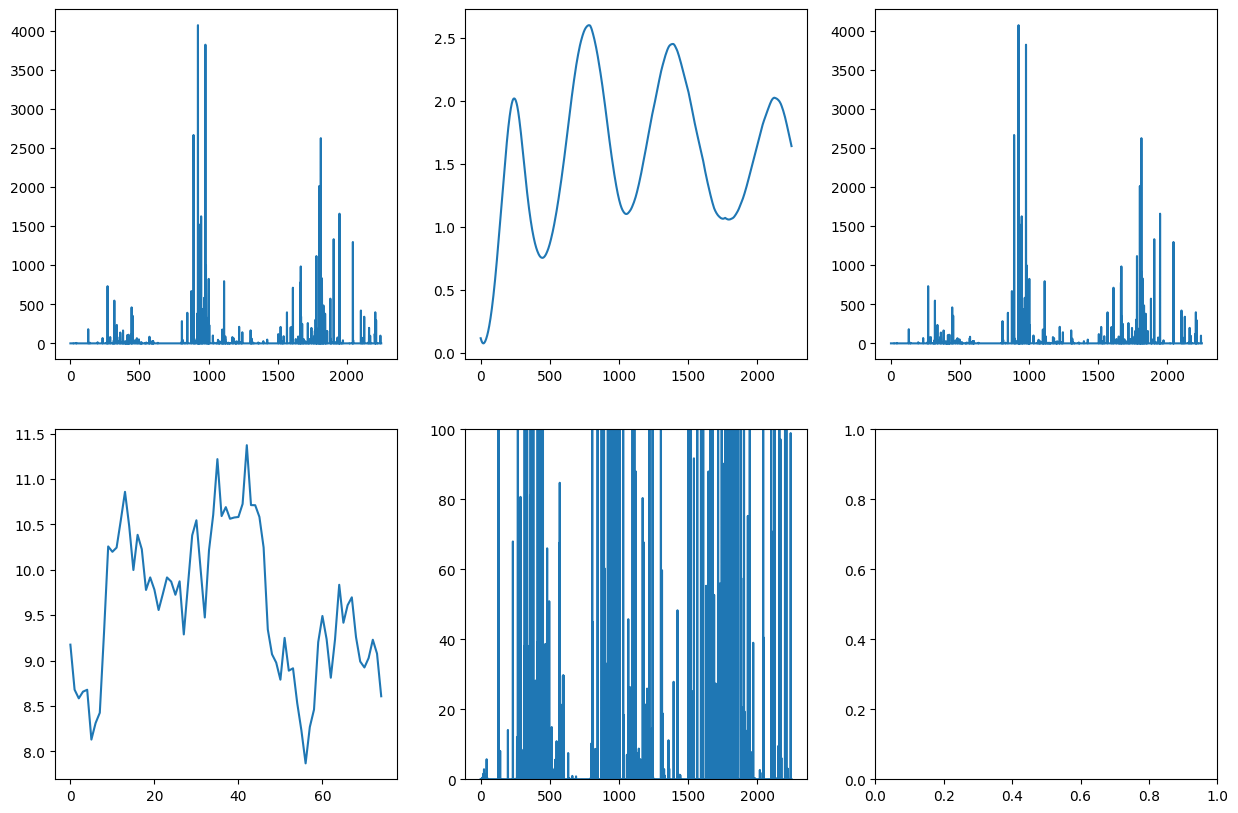

In [22]:
fig, axis = plt.subplots(2, 3, figsize=(15, 10))

axis[0, 0].plot(mse_plan_history)
axis[0, 1].plot(kl_plan_history)
axis[0, 2].plot(loss_plan_history)

# zoom
axis[1, 0].plot(history_summed_reward)
axis[1, 1].plot(loss_plan_history)
axis[1, 1].set_ylim(0, 100)

In [69]:
multibuffer.elem_for_buffer

defaultdict(<function buffers.MultiEnvReplayBuffer.__init__.<locals>.<lambda>()>,
            {18: 2000,
             36: 900,
             35: 900,
             4: 900,
             37: 900,
             29: 900,
             25: 900,
             46: 900,
             26: 900,
             1: 900})